# Import Libraries

In [1]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from autosklearn.classification import AutoSklearnClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

# Load the Dataset

In [2]:
train_df = pd.read_csv("../data/train_split.csv")

In [3]:
train_df.head()

,skewness,curtosis,entropy,y
0,7.2590,0.070827,-7.30040,1
1,3.3998,-4.432700,-4.26550,1
2,-9.2828,7.719000,-1.71680,1
3,-3.6792,3.828100,1.62970,0
4,6.8369,0.697180,-0.55691,0


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   skewness  1097 non-null   float64
 1   curtosis  1097 non-null   float64
 2   entropy   1097 non-null   float64
 3   y         1097 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 34.4 KB


- There are no missing values in the dataset.

In [5]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
skewness,1097.0,1.841192,5.856025,-13.6779,-1.7837,2.23690,6.81620,12.9516
curtosis,1097.0,1.438955,4.341728,-5.2861,-1.5323,0.65005,3.36620,17.6772
entropy,1097.0,-1.137623,2.045680,-8.5482,-2.2134,-0.57242,0.39481,2.4495
y,1097.0,0.444850,0.497176,0.0000,0.0000,0.00000,1.00000,1.0000


# Split the Dataset

In [6]:
X, y = train_df.drop(columns=["y"]), train_df["y"]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Modeling

Auto-Sklearn is responsible for the following tasks:

* **Data Preprocessing**: prepares the data for machine learning models. This can include handling missing values, one-hot encoding of categorical features, and normalization of features.
* **Search Space Definition**: defines a search space that includes various machine learning models and preprocessing methods. By default, it searches a large space to find a well-performing configuration. 
* **Model Training**: It trains multiple models on the dataset using different configurations. It optimizes both the machine learning models and builds an ensemble out of them.
* **Model Selection**: It uses some techniques like *Bayesian optimization*, *meta-learning*, and *ensemble construction* to select the best model.
* **Model Evaluation**: After the models are trained, AutoSklearn evaluates their performance. It offers methods to inspect the training results.

In [8]:
automl_clf = AutoSklearnClassifier(
    time_left_for_this_task=600,  # Max 10 minutes
    resampling_strategy="cv",
    resampling_strategy_arguments={"folds": 5},
)

In [9]:
automl_clf.fit(X_train, y_train)

/home/mmostafa/miniconda3/envs/aienv9/lib/python3.9/site-packages/autosklearn/data/feature_validator.py:298: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(X[column]):


AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      per_run_time_limit=60, resampling_strategy='cv',
                      resampling_strategy_arguments={'folds': 5},
                      time_left_for_this_task=600)

# Model Evaluation

In [10]:
y_pred = automl_clf.predict(X_test)

In [11]:
# Show Accuracy, Precision, Recall, F1 Score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       122
           1       0.93      0.97      0.95        98

    accuracy                           0.95       220
   macro avg       0.95      0.96      0.95       220
weighted avg       0.96      0.95      0.95       220



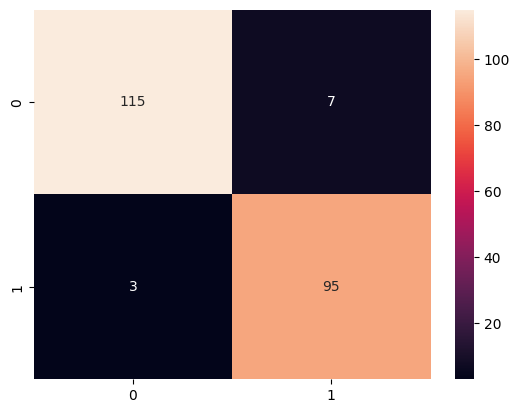

In [12]:
# Show the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

* The model is perfect for the test data.

In [13]:
y_proba = automl_clf.predict_proba(X_test)

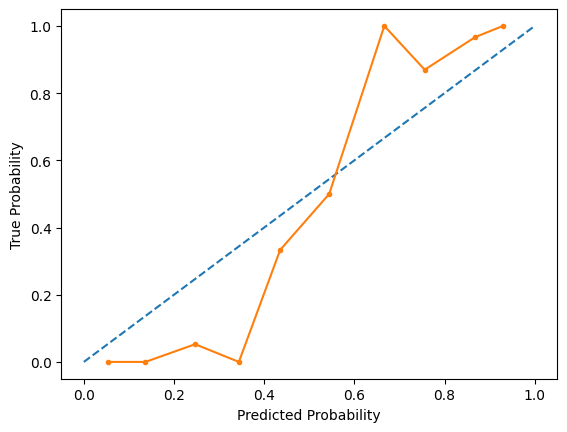

In [14]:
prob_true, prob_pred = calibration_curve(y_test, y_proba[:, 1], n_bins=10)

# Plot the Calibration Curve for the base model
plt.plot([0, 1], [0, 1], linestyle="--")
plt.plot(prob_pred, prob_true, marker=".")
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.show()

* The model needs to be calibrated.

# Model Calibration

In [15]:
# Calibrating the model using logistic calibration
calibrated_clf = CalibratedClassifierCV(automl_clf, cv=5, method="sigmoid")

calibrated_clf.fit(X_train, y_train)

/home/mmostafa/miniconda3/envs/aienv9/lib/python3.9/site-packages/autosklearn/data/feature_validator.py:298: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(X[column]):
/home/mmostafa/miniconda3/envs/aienv9/lib/python3.9/site-packages/autosklearn/data/feature_validator.py:298: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(X[column]):
/home/mmostafa/miniconda3/envs/aienv9/lib/python3.9/site-packages/autosklearn/data/feature_validator.py:298: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(X[column]):
/home/mmostafa/miniconda3/envs/aienv9/lib/python3.9/site-packages/autosklearn/data/feature_validator.py:298: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

CalibratedClassifierCV(cv=5,
                       estimator=AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                                                       per_run_time_limit=60,
                                                       resampling_strategy='cv',
                                                       resampling_strategy_arguments={'folds': 5},
                                                       time_left_for_this_task=600))

In [16]:
# Evaluating the calibrated model
calib_y_proba = calibrated_clf.predict_proba(X_test)

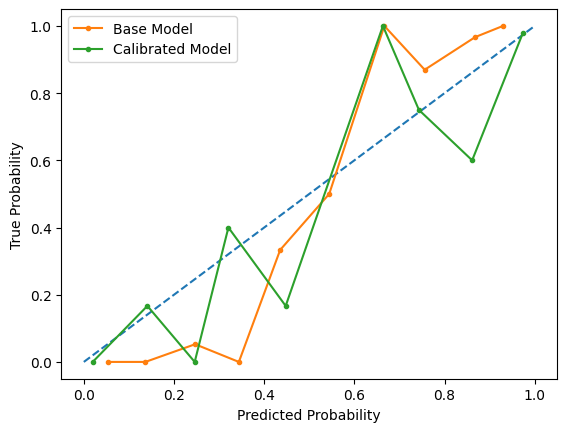

In [17]:
calib_prob_true, calib_prob_pred = calibration_curve(
    y_test, calib_y_proba[:, 1], n_bins=10
)

# Plot the Calibration Curve for the calibrated model, and compare it with the base model
plt.plot([0, 1], [0, 1], linestyle="--")
plt.plot(prob_pred, prob_true, marker=".", label="Base Model")
plt.plot(calib_prob_pred, calib_prob_true, marker=".", label="Calibrated Model")
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.legend()
plt.show()

# Save the Model

In [18]:
# Save the calibrated model as a pickle file
with open("../models/calibrated_model.pkl", "wb") as f:
    pickle.dump(calibrated_clf, f)

: 